# Лабораторная работа №3. Синтез БИХ-фильтров




## Модуль 1. Метод размещения нулей и полюсов.


### Задача 1.1 Синтез цифрового резонатора

| Варианты: |   $1$ |    $2$ |    $3$ |    $4$ |    $5$ |    $6$ |     $7$ |    $8$ |    $9$ |    $10$ | 
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|  $\nu_0$  | $0.25$ | $0.2$ | $0.1$ |  $—$ | $—$ | $—$ | $0.3$ | $0.15$ | $0.35$ | $0.4$ |
|$\theta_0$ | $—$ | $—$ | $—$ | $\dfrac\pi6$ | $\dfrac\pi3$ | $\dfrac\pi2$ |  $—$ | $—$ | $—$ | $—$ |

Синтезировать методом размещения нулей и полюсов цифровой резонатор для частоты $\nu_0$ или $\theta_0$ (в зависимости от варианта). Параметр, влияющий на добротность резонатора, подобрать самостоятельно.

* Построить нуль-полюсную диаграмму получившегося фильтра.
* Записать передаточную функцию $H(z)$.
* Вычислить аналитически импульсную и переходную характеристики и сравнить с результатами моделирования.
* Исследовать фильтр на устойчивость по входу.
* Изобразить блок-схему фильтра.
* Построить АЧХ и ФЧХ фильтра.
* Сравнить АЧХ с $H(z)$.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.ticker as ticker
%matplotlib inline
# %matplotlib notebook

In [11]:
# Python класс для анализа фильтра
class Filter:
    def __init__(self, dlti_args, fs=1.0):
        #         Инициализация на основе объекта signal.dlti
        self.fs = fs
        self.system_dlti = signal.dlti(*dlti_args, dt=1.0 / fs)
        self.alpha_beta()
        self.zpk()

    def alpha_beta(self):
        #         Вычисление коэффициентов alpha beta
        system = signal.TransferFunction(self.system_dlti)
        self.beta = system.num
        self.alpha = system.den

    def zpk(self):
        #         Вычисление нулей, полюсов и множителя
        system = self.system_dlti.to_zpk()
        self.zeros = system.zeros
        self.poles = system.poles
        self.gain = system.gain

    def zpk_plot(self):
        #         Нуль-полюсная диаграмма
        plt.figure()
        q = np.linspace(0, 2 * np.pi, 401)
        ax = plt.axes()
        ax.set_aspect(aspect="equal", adjustable="datalim")
        plt.plot(np.cos(q), np.sin(q), "k--")
        plt.plot(self.zeros.real, self.zeros.imag, "ro", label="Нули")
        plt.plot(self.poles.real, self.poles.imag, "bx", label="Полюса")
        plt.grid()
        plt.legend()  # bbox_to_anchor=(1.05, 1), loc=2, numpoints=1
        plt.title("Нуль-полюсная диаграмма")
        plt.xlabel("Re $z$")
        plt.ylabel("Im $z$")
        plt.tight_layout()
        plt.show()

    def H(self, z):
        #         Вычисление функции H(z) для заданного z. Требует предварительного вычисления нулей и полюсов.
        H = self.gain + 0
        for z1 in self.zeros:
            H *= z - z1
        for p1 in self.poles:
            H /= z - p1
        return H

    def abs_H_plot(self):
        #         Трехмерный график |H(z)|
        fig = plt.figure(dpi=160)
        ax = plt.axes(projection="3d")
        Re = np.arange(-1.2, 1.2, 0.1)
        Im = np.arange(-1.2, 1.2, 0.1)
        Re, Im = np.meshgrid(Re, Im)
        Z1 = Re + 1j * Im

        Z = abs(self.H(Z1))
        Z = np.minimum(Z, 40 * np.ones(Z.shape))

        phi = np.linspace(0, 2 * np.pi, 500)
        # ax.plot_surface(Re, Im, Z, linewidth=0, antialiased=True, color='silver')
        ax.plot_wireframe(Re, Im, Z, color="silver")

        for u in phi:
            Z1 = np.exp(-1j * u)
            Z2 = abs(self.H(Z1))
            ax.plot(
                [Z1.real, Z1.real],
                [Z1.imag, Z1.imag],
                [0.0, Z2],
                color=(abs(np.cos(u)), 0.7, 0.5),
            )

        Z1 = np.exp(-1j * phi)
        Z2 = abs(self.H(Z1))

        ax.plot(Z1.real, Z1.imag, Z2, linewidth=2, color="b")

        ax.set_zlim(0, 1.2 * max(Z2))
        ax.set_xticks(np.linspace(-1, 1, 5))
        ax.set_yticks(np.linspace(-1, 1, 5))
        ax.set_zticks(np.linspace(0, max(Z2), 5))
        ax.view_init(40, 240)
        ax.set_xlabel("Re $z$")
        ax.set_ylabel("Im $z$")

        ax.zaxis.set_rotate_label(False)  # disable automatic rotation
        ax.set_zlabel("$|H(z)|$", rotation=0)
        plt.tight_layout()

    def lfilter_resp(self, x):
        #         Фильтрация заданного сигнала
        return signal.lfilter(self.beta, self.alpha, x)

    def lfilt_plot(self, x, label="y"):
        self.alpha_beta()
        #         График сигнала на выходе фильтра при заданном входе
        y = self.lfilter_resp(x)
        plt.figure(figsize=[8, 3])
        plt.title("Сигнал на выходе фильтра")
        plt.stem(np.arange(y.shape[0]), y)
        plt.xlabel("$k$")
        plt.ylabel("$%s[k]$" % label)
        plt.tight_layout()
        plt.grid()

    def step_resp_plot(self, n=20):
        t, y = signal.dstep(self.system_dlti, n=n)
        plt.figure(figsize=[8, 3])
        plt.title("Переходная характеристика")
        y = np.squeeze(y)
        plt.stem(np.arange(len(y)), y)
        plt.xlabel("$k$")
        plt.ylabel("$g[k]$")
        plt.tight_layout()
        plt.grid()

    def impulse_resp_plot(self, n=20):
        t, y = signal.dimpulse(self.system_dlti, n=n)
        plt.figure(figsize=[8, 3])
        plt.title("Импульсная характеристика")
        y = np.squeeze(y)
        plt.stem(np.arange(len(y)), y)
        plt.xlabel("$k$")
        plt.ylabel("$h[k]$")
        plt.tight_layout()
        plt.grid()

    def freqresp_plot(self, f_scale="f", whole=True):
        #         АЧХ фильтра
        w, H = self.system_dlti.freqresp(w=None, n=2**18, whole=whole)
        if whole:
            w, H = w - np.pi, np.fft.fftshift(H)
        figure1 = plt.figure(figsize=[8, 6])
        ax1 = plt.subplot(2, 1, 1)
        ax2 = plt.subplot(2, 1, 2)

        for ax in [ax1, ax2]:
            if f_scale == "f":
                f = self.fs * (w / (2 * np.pi)) / 1e3
                ax.set_xlabel("$f$, кГц")
            elif f_scale == "\\nu":
                f = w / (2 * np.pi)
                ax.set_xlabel("$%s$" % f_scale)
            elif f_scale == "\\theta":
                f = w
                ax.set_xlabel("$%s$, рад" % f_scale)
            ax.set_xlim([f[0], f[-1]])
            ax.grid()

        ax1.set_title("AЧХ фильтра")
        ax1.plot(f, abs(H))
        ax1.set_ylabel("$|H(%s)|$" % f_scale)

        ax2.plot(f, np.angle(H))
        ax2.set_ylabel("$\\varphi(%s)$" % f_scale)
        ax2.set_yticks(
            [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi],
            labels=("$-\\pi$", "$-\\pi/2$", "$0$", "$\\pi/2$", "$\\pi$"),
        )
        plt.tight_layout()

In [23]:
theta_0 = np.pi / 6
f_0 = theta_0 / (np.pi * 2)

beta, alpha = signal.iirpeak(f_0, Q=5, fs=1)
filt = Filter(dlti_args=(beta, alpha))

from IPython.display import display, Latex
def latex_elem(elem, power, last=False) -> str:
  res = ""
  if elem != 0.0:
    res = f"\\left({elem}\\right)"
    if power != 0:
      res += f"\\cdot z^{{{power}}}"
    if not last:
      res += " + "
  return res

display(Latex(f"""\
$$
H\\left(z\\right) =
\\dfrac{{
  {"".join(latex_elem(b, -i, i == 2) for i, b in enumerate(beta))}
}}{{
  {"".join(latex_elem(a, -i, i == 2) for i, a in enumerate(alpha))}
}}
$$"""))

<IPython.core.display.Latex object>

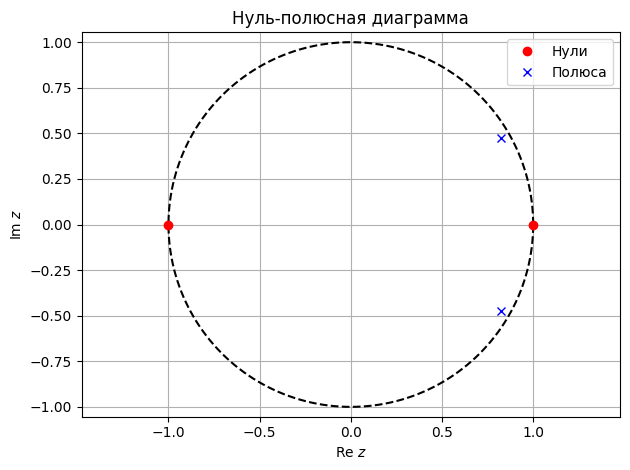

In [24]:
filt.zpk_plot()

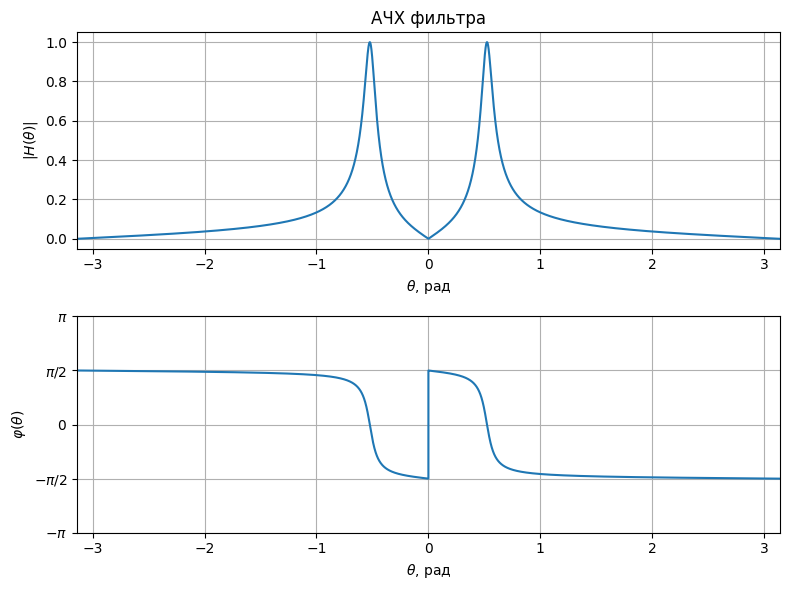

In [25]:
filt.freqresp_plot(f_scale='\\theta')

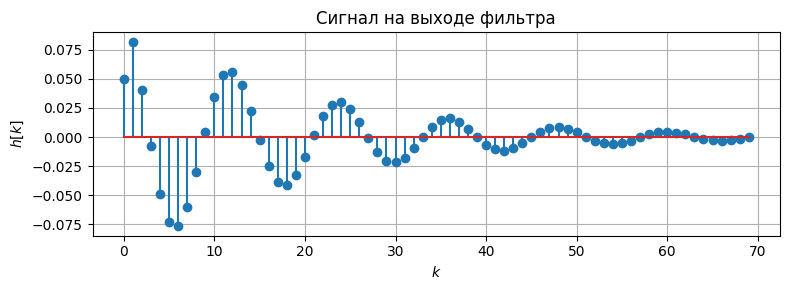

In [30]:
filt.lfilt_plot(signal.unit_impulse(70), label="h")

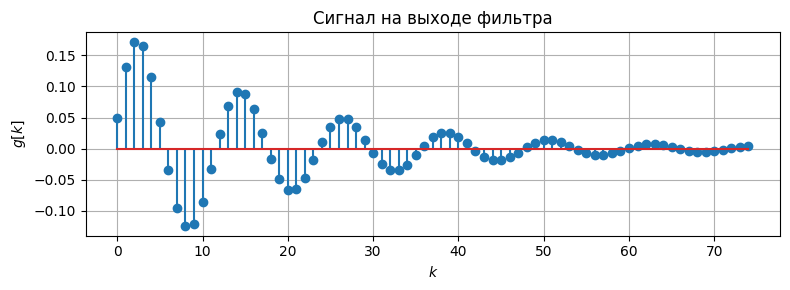

In [32]:
filt.lfilt_plot(np.ones(75), label="g")

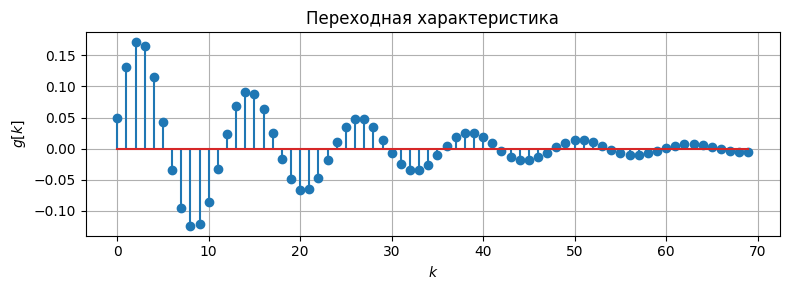

In [34]:
filt.step_resp_plot(n=70)

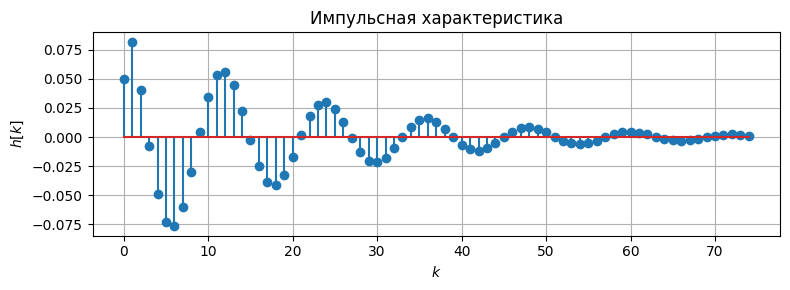

In [36]:
filt.impulse_resp_plot(n=75)

### Задача 1.2 Синтез цифрового фильтра Hum removal

| Варианты: |   1 |    2 |    3 |    4 |    5 |    6 |    7 |    8 |    9 |   10 |  
|:---------:|----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
|  $f_0$, Гц  | 250 | 350 | 400 |  200 | 100 | 150 | 250 | 500| 600 | 350 |
|  $f_д$, Гц | 1000 | 1000 | 1000 | 500 | 500 | 500 | 1000 | 2000 | 2000 | 2000 |

Синтезировать методом размещения нулей и полюсов цифровой фильтр Hum removal  для частоты $f_{0}$, $f_{д}$. Параметр, влияющий на добротность, подобрать самостоятельно.

* Записать передаточную функцию $H(z)$.
* Исследовать фильтр на устойчивость по входу.
* Изобразить блок-схему фильтра.
* Построить АЧХ и ФЧХ фильтра.
* Сравнить АЧХ с $H(z)$.
